# Сегментация клиентской базы сети фитнес-центров

## Общее описание проекта
Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Одна из проблем фитнес-клубов — отток клиентов. Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас. 

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

**Аналитическая задача** — провести анализ и подготовить план действий по удержанию клиентов. 

**Для решения поставленной задачи** необходимо:
1. Сформировать типичные портреты клиентов: 
    - выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
2. Проанализировать основные признаки, наиболее сильно влияющие на отток;
3. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.
    
## Описание данных
Заказчик предоставил клиентскую базу, содержащую данные на месяц до оттока и факт оттока на определённый месяц. Каждая запись характеризуется следующим единым набором признаков, описывающих клиента:

**за месяц до проверки факта оттока**

|**Признак**|**Описание признака**|
|---:|:---|
|`gender`|пол|
|`Near_Location`|проживание или работа в районе, где находится фитнес-центр|
|`Partner`|сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)|
|`Promo_friends`|факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)|
|`Phone`|наличие контактного телефона|
|`Age`|возраст|
|`Lifetime`|время с момента первого обращения в фитнес-центр (в месяцах)|

**за месяц, в котором проводилась проверка факта оттока**

|**Признак**|**Описание признака**|
|---:|:---|
|`Contract_period`|длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)|
|`Month_to_end_contract`|срок до окончания текущего действующего абонемента (в месяцах)|
|`Group_visits`|факт посещения групповых занятий|
|`Avg_class_frequency_total`|средняя частота посещений в неделю за все время с начала действия абонемента|
|`Avg_class_frequency_current_month`|средняя частота посещений в неделю за предыдущий месяц|
|`Avg_additional_charges_total`|суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон|
|`Churn`|факт оттока в текущем месяце|

### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from scipy import stats as st
import math 

from IPython.display import Image
from tqdm.auto import tqdm
from scipy.stats import norm

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
pd.options.display.precision = 2
pd.options.display.float_format ='{:.2f}'.format

### Загружаем данные и знакомимся с ними

In [3]:
df = pd.read_csv('project5.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [4]:
df.tail()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3995,1,1,1,0,1,12,0,33,2.41,12.00,8,2.28,2.35,0
3996,0,1,0,0,1,1,1,29,68.88,1.00,1,1.28,0.29,1
3997,1,1,1,1,1,12,0,28,78.25,11.00,2,2.79,2.83,0
3998,0,1,1,1,1,6,0,32,61.91,5.00,3,1.63,1.60,0
3999,1,0,1,0,0,12,1,30,178.86,12.00,1,1.10,1.04,0


Данные загружены корректно. Как видим, данные в основном категориальные. Для удобства переведу заголовки колонок в нижний регистр.

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.head(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0


Посмотрим на общую информацию по типам и объем датафрейма.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [8]:
print('Количество строк -- {}, количество колонок -- {}'.
     format(df.shape[0], df.shape[1]))

Количество строк -- 4000, количество колонок -- 14


Также посмотрим на наличие дублирующих значений и перепроверим пропуски в значениях.

In [9]:
print('Количество дублирующихся записей -- {}. Это составляет -- {:.2%} от общего числа записей.'.
      format(df.duplicated().sum(), df.duplicated().sum()/df.shape[0]))

Количество дублирующихся записей -- 0. Это составляет -- 0.00% от общего числа записей.


In [10]:
df.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Отлично!!! Пропусков нет, дубликатов тоже нет. Работаем дальше...

Для подписей на графиках применю функцию перевода заголовков на русский язык.

In [11]:
dict_to_rus = {
'gender': 'пол',
'near_location': 'локация клиента',                        
'partner': 'клиент компании-партнера',                              
'promo_friends': 'акция "приведи друга"',                        
'phone': 'номер телефона',                                
'contract_period': 'длительность текущего абонемента',                      
'group_visits': 'факт посещения групповых занятий',                         
'age': 'возраст',                                  
'avg_additional_charges_total': 'суммарная выручка от других услуг',         
'month_to_end_contract': 'срок до окончания текущего абонемента',                
'lifetime': 'время с момента первого обращения',                             
'avg_class_frequency_total': 'средняя частота посещений в неделю сначала',            
'avg_class_frequency_current_month': 'средняя частота посещений в неделю за предыдущ.месяц',    
'churn': 'отток(0-остался,1-ушел)'
} 

Посмотрим на описательную статистику.

In [12]:
pd.concat([pd.DataFrame(list(dict_to_rus.values()), index = list(dict_to_rus.keys()), columns = ['расшифровка']), 
           df.describe().T], axis = 1, sort = False)

,расшифровка,count,mean,std,min,25%,50%,75%,max
gender,пол,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,локация клиента,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,клиент компании-партнера,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"акция ""приведи друга""",4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,номер телефона,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,длительность текущего абонемента,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,факт посещения групповых занятий,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,возраст,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,суммарная выручка от других услуг,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,срок до окончания текущего абонемента,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


По описательным статистикам явных аномальных значений не наблюдается.

### Анализ данных

Попробуем провести дополнительное исследование выделенных признаков. Возможно попутно удастся получить дополнительные полезные сведения. Воспользуемся визуализацией.

Разделим выбранную совокупность признаков на категориальные и интервальные, и будем обрабатывать их отдельно.

$\blacktriangleright$ Анализ категориальных признаков
<a class="anchor" id="category_var"></a>

In [13]:
category_ = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 
             'month_to_end_contract', 'lifetime', 'churn']

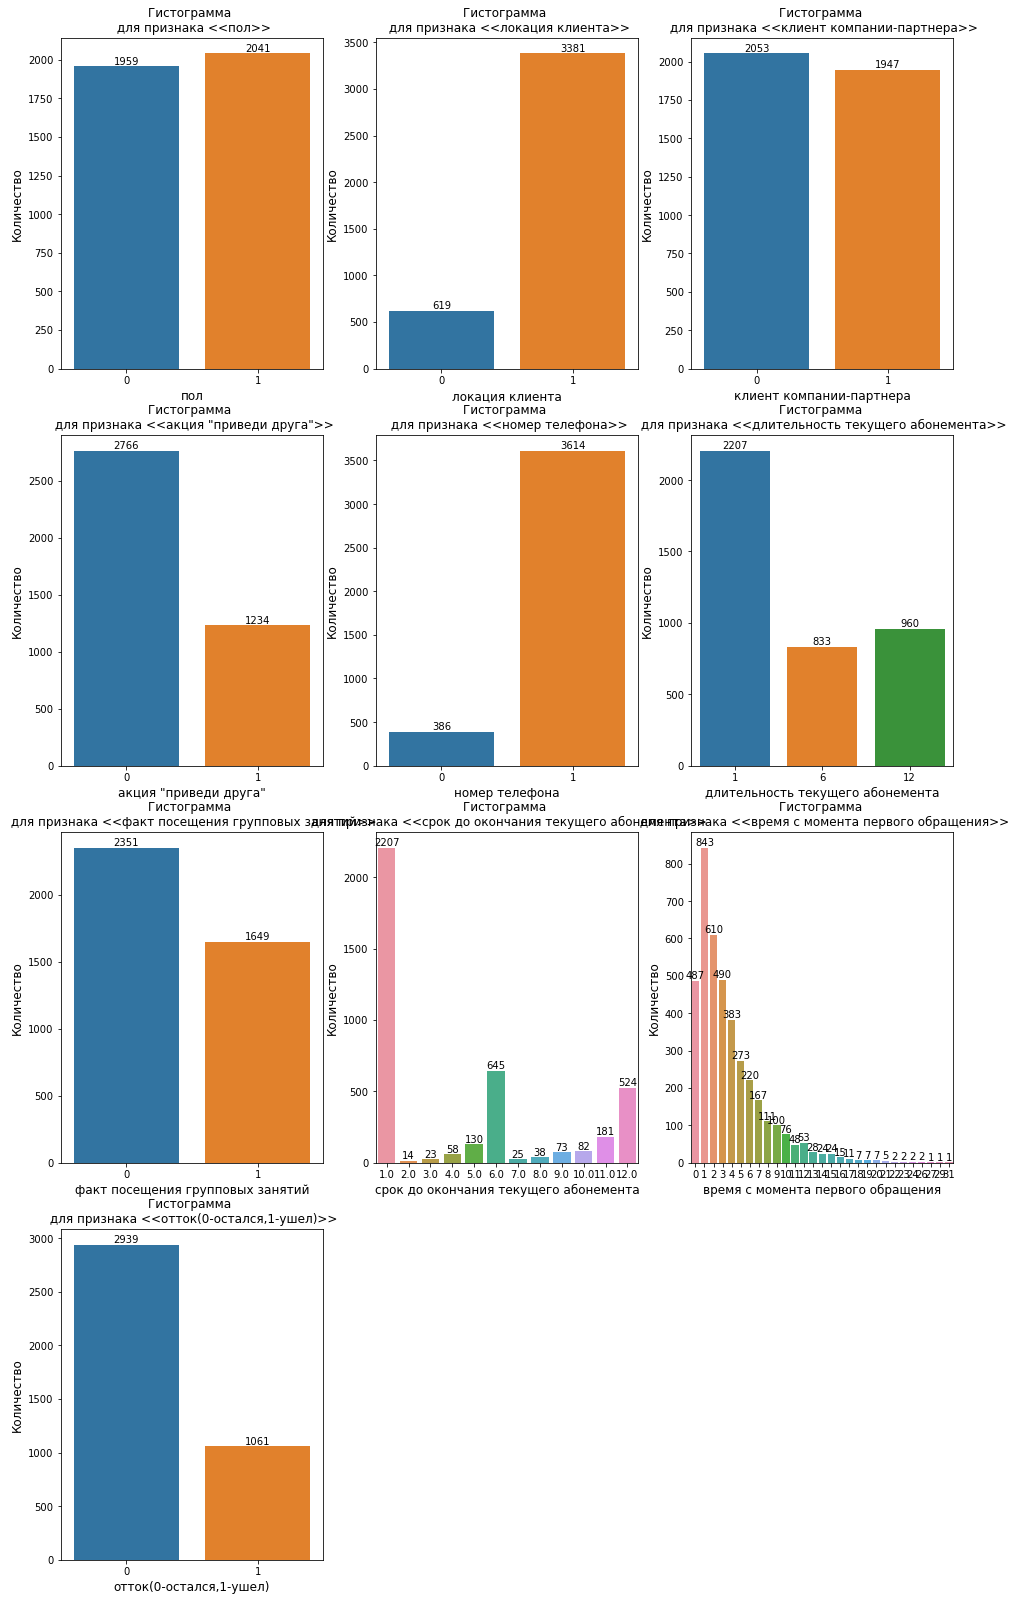

In [14]:
fig, axes = plt.subplots(3, sharey=True, figsize=(16,28))
i=0
for i, col in enumerate(category_):
    plt.subplot(4,3,i+1)
    ax = sns.countplot(x=col, data=df,)
    plt.title("Гистограмма \n для признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col], fontsize = 12)
    plt.ylabel('Количество', fontsize = 12)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:d}'.format(p.get_height()), 
            (x.mean(), y),ha='center', va='bottom', fontsize = 10);

**Промежуточный вывод по категориальным признакам:**

- примерно одинаковое количество мужчин и женщин посещает фитнес-центр;
- основная часть клиентов живет по-близости с фитнес-центром;
- клиентов компаний-партнеров приблизительно столько же, что и клиентов не являющимися сотрудниками компаний-партнеров;
- половина клиентов из всей выборки пользуются акцией "приведи друга";
- 10% из всех клиентов не оставляют номера телефонов;
- Больше половины из всей выборки клиенты выбирают абонемент длительностью один месяц;
- групповые занятия посещают чуть больше половины клиентов;
- у большинства клиентов до окончания текущего абонемента остается один месяц;
- в среднем прошло около 3.7 месяца с момента первого обращения в фитнес-центр; 
- около 27% клиентов покинули фитнес-центр в текущем месяце.

$\blacktriangleright$ Анализ интервальных признаков
<a class="anchor" id="category_var"></a>

In [15]:
interval_ = ['age', 'avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

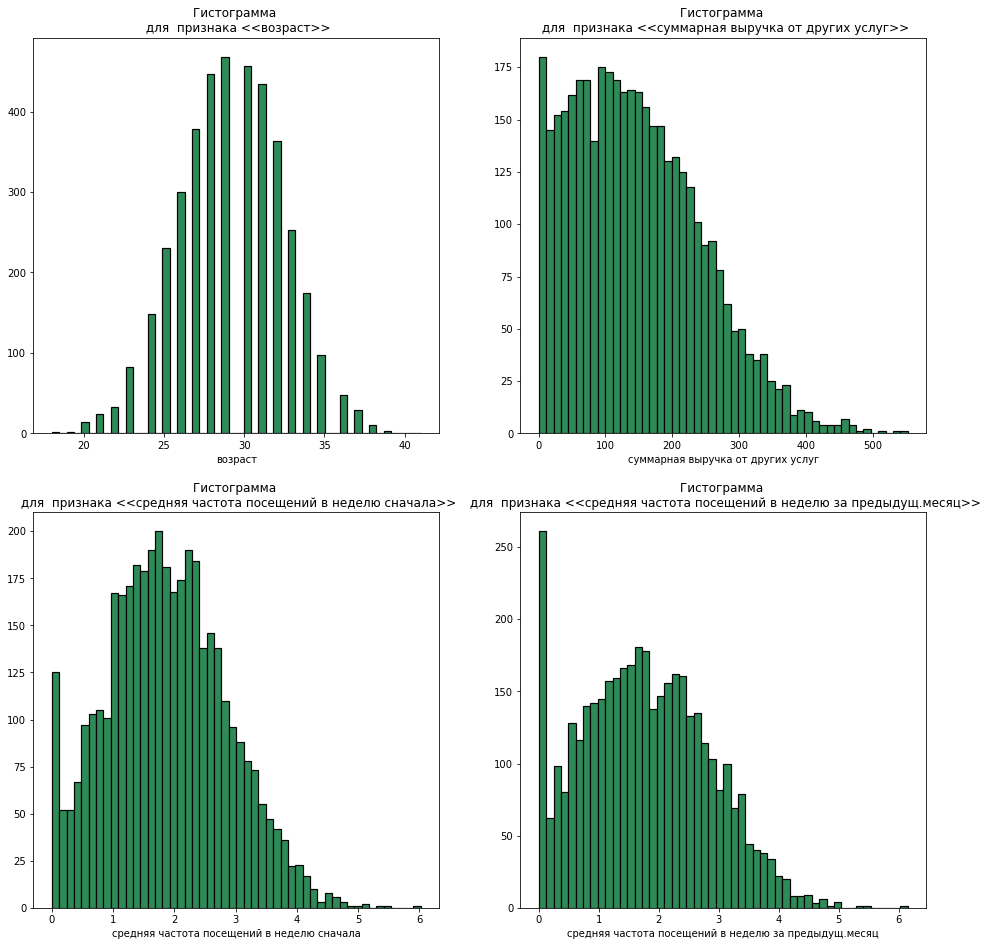

In [16]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))
i = 0
l = 0
j = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(df[interval_[l]], bins = 50, color = "seagreen", edgecolor='black', linewidth=1.2)
        axes[i, j].set_title("Гистограмма \n для  признака <<{}>>".format(dict_to_rus[interval_[l]]))
        axes[i, j].set_xlabel(dict_to_rus[interval_[l]])
        l+=1

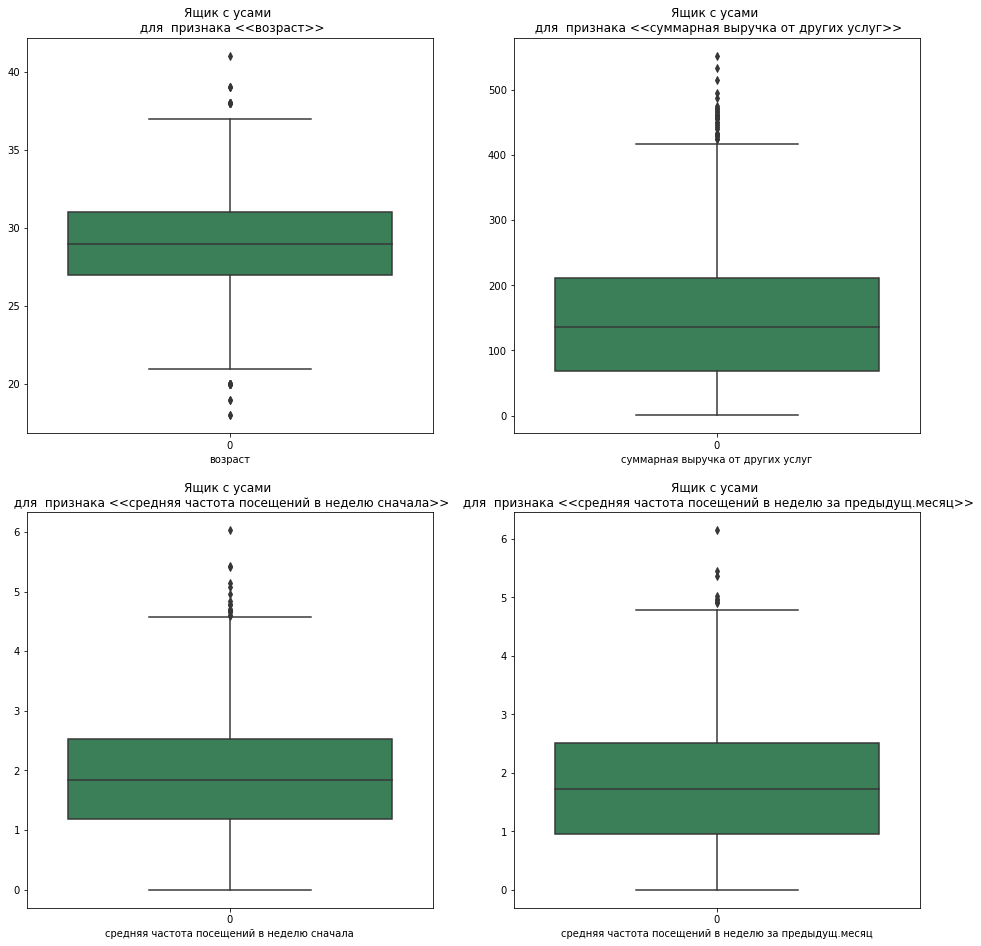

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))
for i, col in enumerate(interval_):
    plt.subplot(2,2,i+1)
    sns.boxplot(data=df[col], whis = 1.5, color = "seagreen")
    plt.title("Ящик с усами \n для  признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col])

**Промежуточный вывод по интервальным признакам:**
    
- средний возраст клиентов 29 лет;
- если рассматривать среднюю частоту посещений в неделю с начала и за предыдущий месяц, то видим примерно одинаковую 
  картину посещения - около двух раз в неделю;
- средняя суммарная выручка составляет 147 ед.

### Исследовательский анализ данных

На данном шаге cоотношение и различия в характеристиках признаков по группам ушел/остался и сформулируем соответствующие гипотезы

In [18]:
intrval_var = ['age', 'avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 
                'contract_period', 'month_to_end_contract', 'lifetime']

$\blacktriangleright$ Визуализация [**интервальных признаков**](#interval_)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


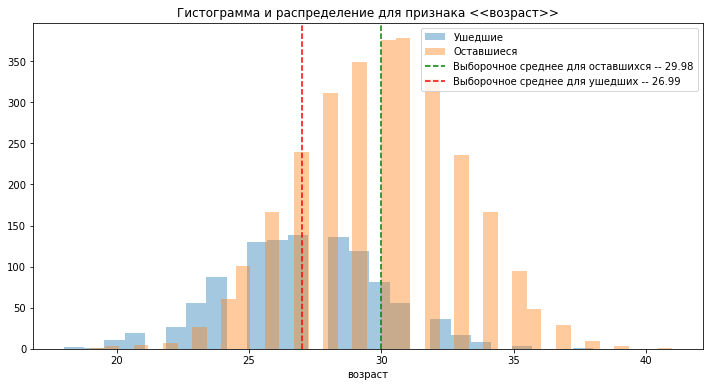

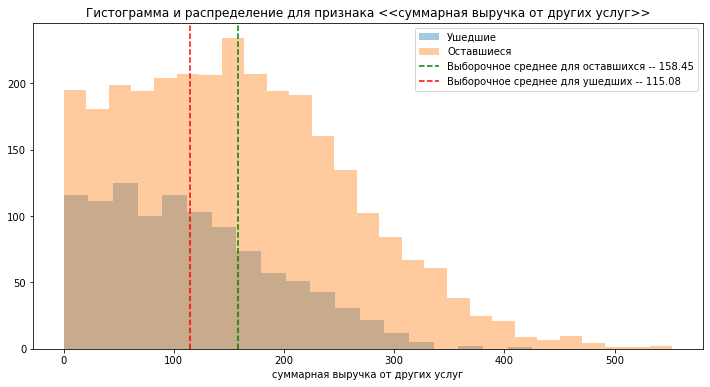

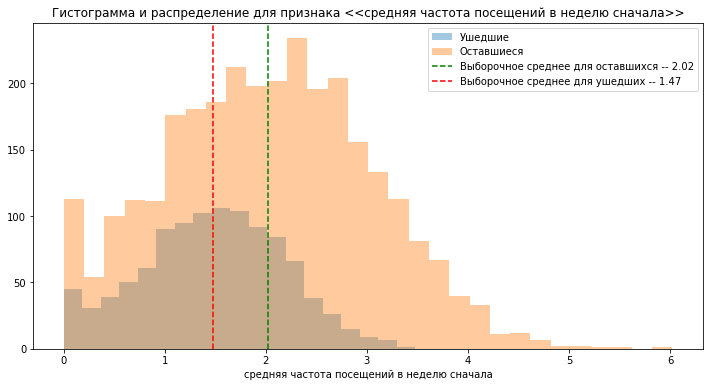

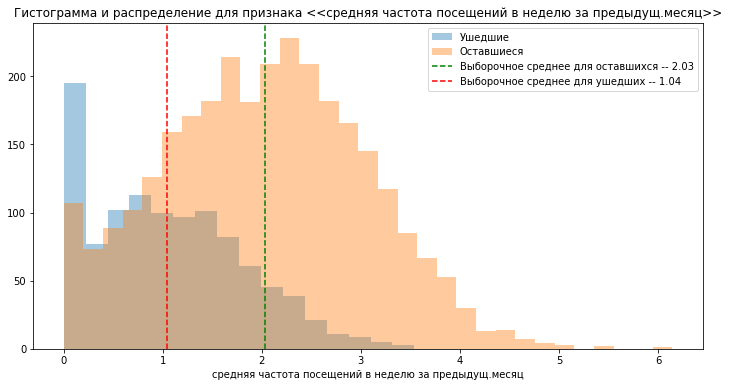

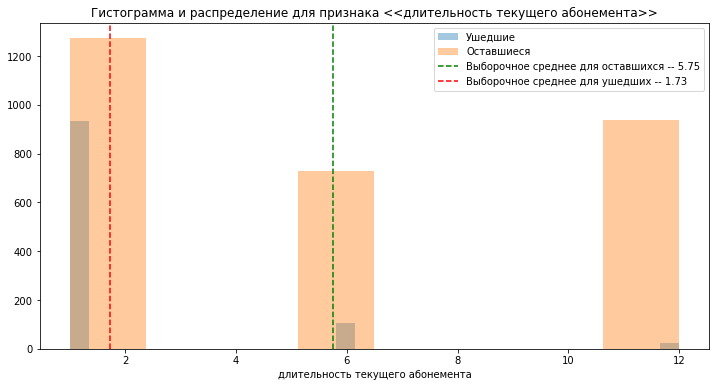

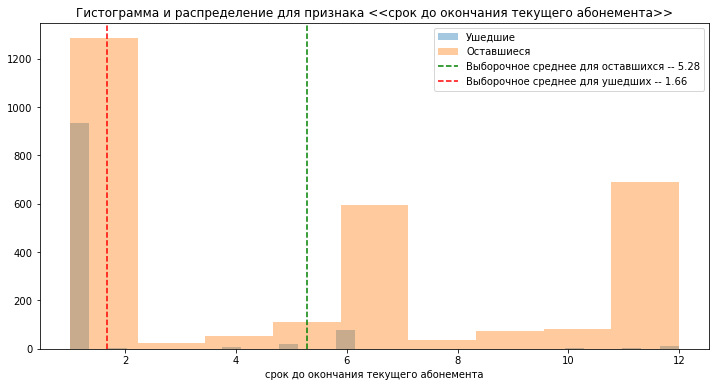

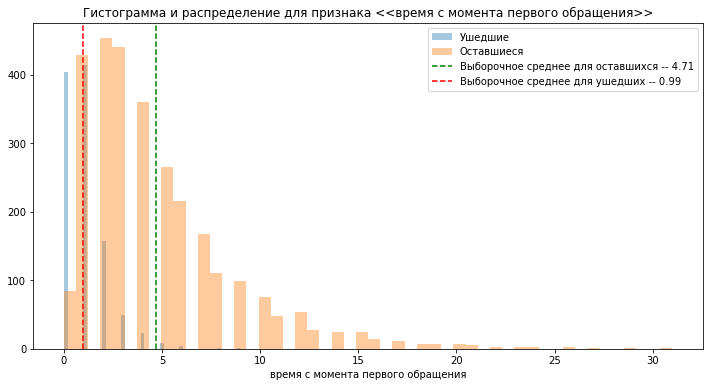

In [19]:
for col in intrval_var:
    plt.figure(figsize=(12,6))
    sns.distplot(df[df.churn == 1][col], label = 'Ушедшие', kde = False)
    sns.distplot(df[df.churn == 0][col], label = 'Оставшиеся', kde = False)
    plt.axvline(df[df.churn == 0][col].mean(),
            color='green',linestyle='--', 
            label = 'Выборочное среднее для оставшихся -- {:.2f}'.\
            format(df[df.churn == 0][col].mean()));
    plt.axvline(df[df.churn == 1][col].mean(),
            color='red',linestyle='--', 
            label = 'Выборочное среднее для ушедших -- {:.2f}'.\
            format(df[df.churn == 1][col].mean()));
    plt.title("Гистограмма и распределение для признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col])
    plt.legend( )
    plt.show()

**По интервальным признакам можно сделать промежуточный вывод:**

- Средний возраст ушедших и оставшихся около 30-ти лет. А также можем заметить, что самые преданные клиенты с возрастом    
  старше 34 лет;
- На другие услуги центра оставшиеся клиенты тратятся больше;
- Выборочное среднее для оставшихся клиентов по средней частоте посещений остается в пределах 2-х раз в неделю с начала  
  посещения и за предыдущий месяц. А вот по ушедшим клиентам можно судить о том, что с начала посещают активнее и со   
  временем посещаю реже;
- Длительность и срок до оканчания текущего абонемента  для ушедших клиентов составляет менее 2-х месяцев, а у оставшихся 
  примерно 6 месяцев;
- По времени момента первого обращения можно сказать, что те клиенты, которые посещают центр долгое время, чаще остаются 
  постоянными клиентами. А вот болинство ушедших были с центром очень мало времени. Необходимо проанализировать по каким 
  критериям новички уходят быстро.  

Для групп оставшихся и ушедших клиентов построим гистораммы для [категориальных признаков](#category_). Однако, прежде, чем переходить к анализу подвергнем модификации набор категориальных признаков, убрав из него признак `churn`.

$\blacktriangleright$ Модификация набора [**категориальных признаков**](#category_)

In [20]:
cat_var = list(set(df.columns) - set(intrval_var) - set(['churn']))

$\blacktriangleright$ Визуализация **категориальных признаков**

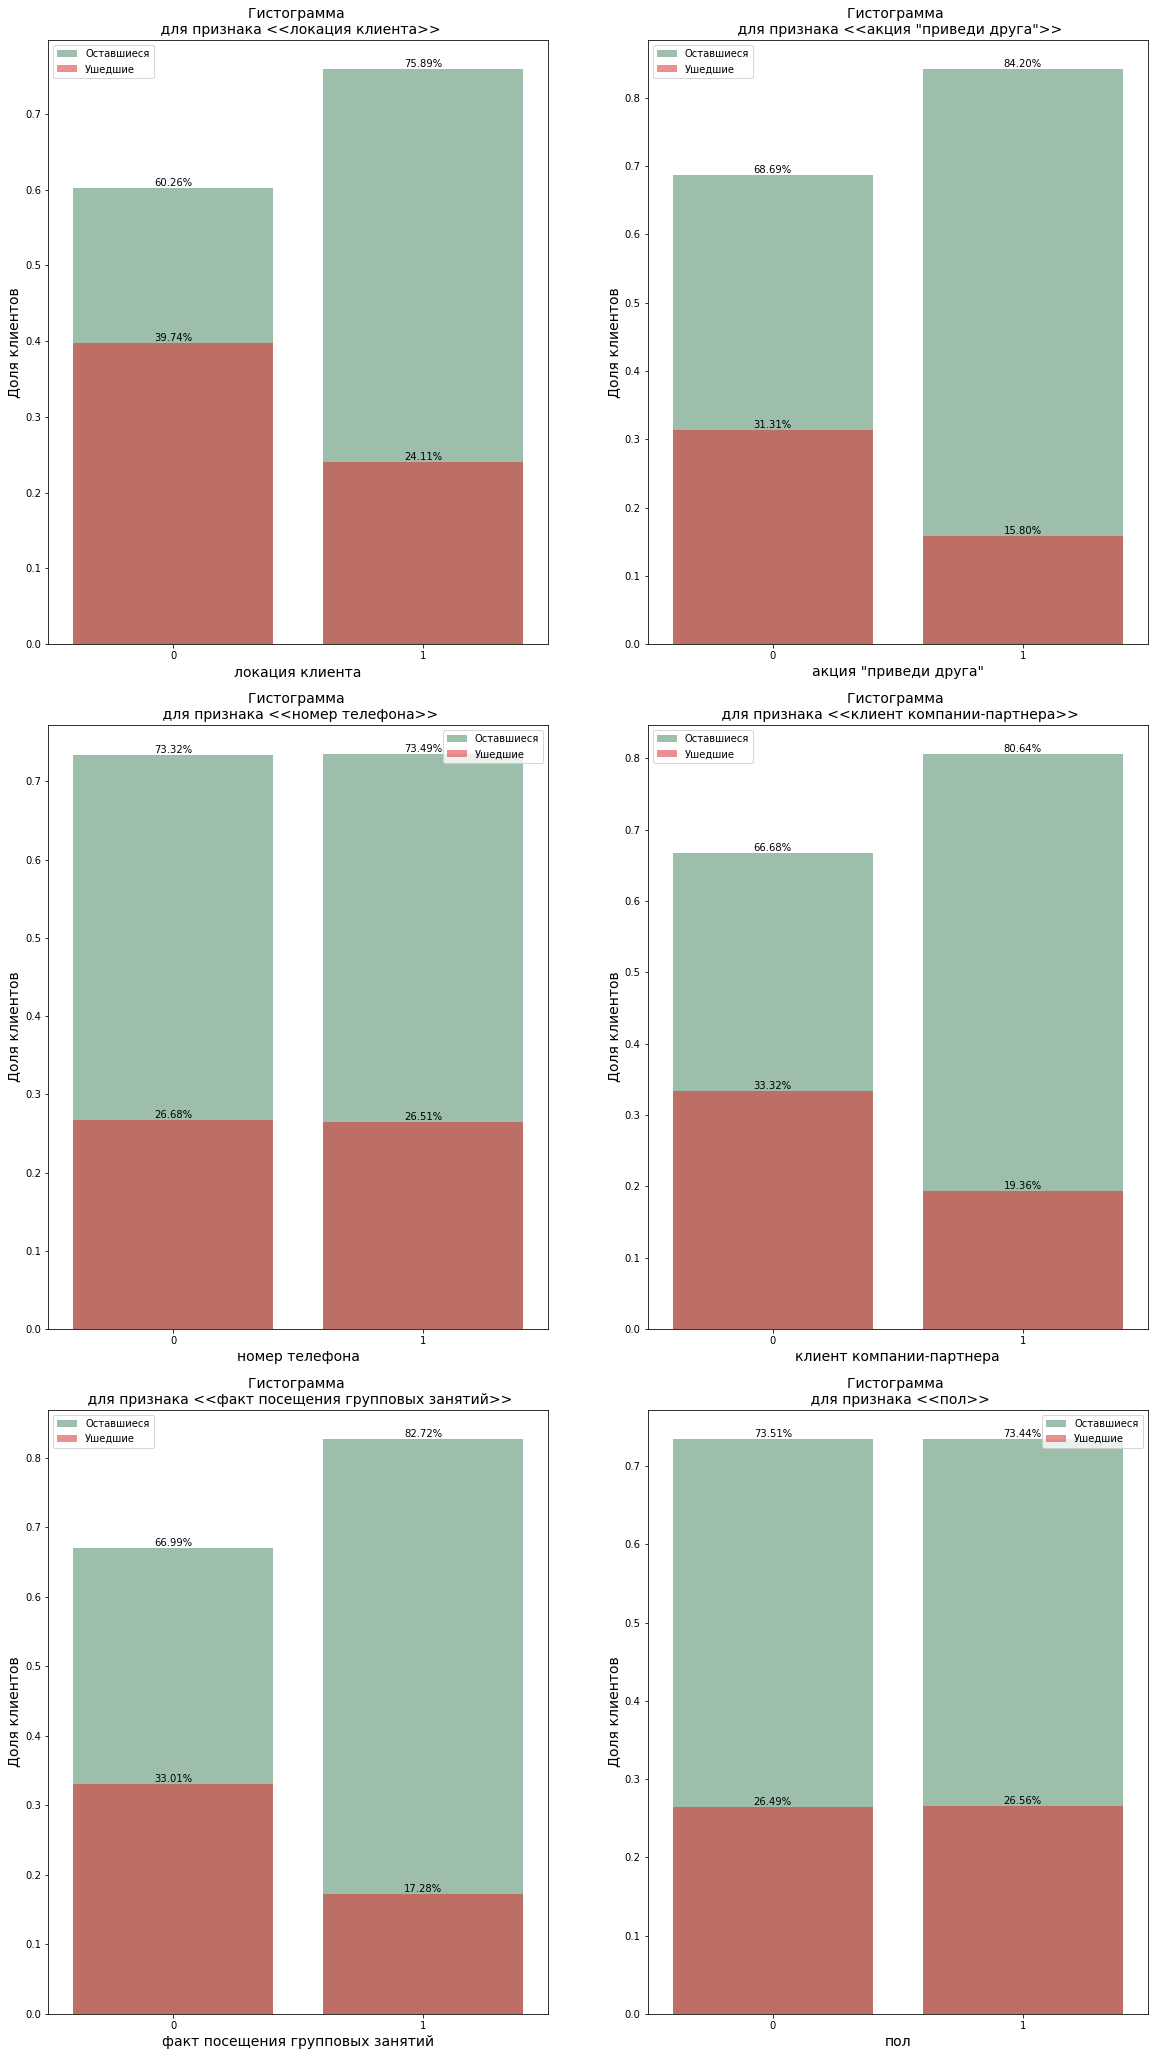

In [21]:
fig, axes = plt.subplots(3, figsize=(16,28))
fig. tight_layout (h_pad= 6)
i=0
for i, col in enumerate(cat_var):
    plt.subplot(3,2,i+1)
    data_all = df[col].value_counts()
    r = (pd.DataFrame([df[df.churn == 0][col].value_counts()/data_all, 
              df[df.churn == 1][col].value_counts()/data_all]).T)
    r.columns = ['0','1']
    ax1 = sns.barplot(x = r.index, y = r['0'], data = r, color='seagreen',
                      alpha = 0.5, label = 'Оставшиеся')
    ax2 = sns.barplot(x = r.index, y = r['1'], data = r, color='red', 
                      alpha = 0.5, label = 'Ушедшие')
    plt.title("Гистограмма \n для признака <<{}>>".format(dict_to_rus[col]), fontsize = 14)
    plt.xlabel(dict_to_rus[col], fontsize = 14)
    plt.ylabel('Доля клиентов', fontsize = 14)
    plt.legend()
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.2f}%'.format(100*y), 
            (x.mean(), y),ha='center', va='bottom', fontsize = 10)

**По категориальным признакам можно сделать промежуточный вывод:**

- Гендерная принадлежность не зависит на отток;
- Тоже можем сказать и про то, оставлял клиент свой номер телефона или нет. Данный признак не зависит на отток;
- Те, кто воспользовался акцией "приведи друга" чаще остаются с центром;
- Факт посещения групповых занятий показал хорошие результаты по отношению к оставшимся клиентам;
- Еще можем заметить, что находящиеся по-близости клиенты остаются постоянными, а вот если локация удаленная, то и клиенты не 
  задерживаются;
- Также клиенты компаний-партнеров остаются больше, чем клиенты без сотрудничества компаний-партнеров.

### Построение и визуализация матрицы корреляций

Для расчета матрицы корреляций воспользуется методом `.corr()`, а для визуализации -- `.heatmap()`. При визуализации воспользуемся тем фактом, что матрица корреляций является симметричной относительно главной диагонали.

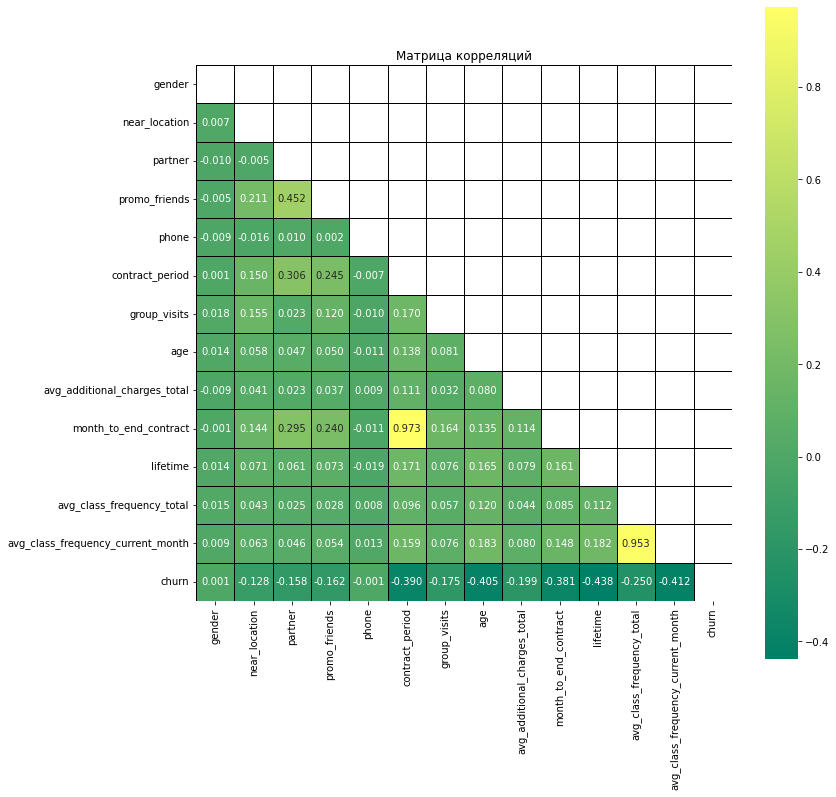

In [22]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(data = df.corr(), annot=True, square=True, 
            cmap='summer', fmt='.3f', linewidths=1, linecolor='black', mask=np.triu(df.corr()))
plt.title('Матрица корреляций')
plt.show()

<a class="anchor" id="matr_corr"></a>
**Вывод по матрице корреляций:** Видим, что для двух пар признаков `month_to_end_contract` и `contract_period`,  `avg_class_frequency_current_month` и `avg_class_frequency_total` соответствующие коэффициенты корреляции близки к единицы. Это означает, что между признаками имеется линейная зависимость. Такие признаки называются [мультиколлинеарными](https://ru.wikipedia.org/wiki/%D0%9C%D1%83%D0%BB%D1%8C%D1%82%D0%B8%D0%BA%D0%BE%D0%BB%D0%BB%D0%B8%D0%BD%D0%B5%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C). В подобных случаях один из признаков (признак с большим коэффициентом корреляции с целевой переменной) исключают из дальнейшего рассмотрения. Ниже, при построении классификационных моделей, сформируем различные  варианты признакового пространства.

Целевой признак `churn` не имеет тесной линейной зависимости от какого-либо из объясняющих признаков. Однако заметим, что среди всех признаки `contract_period`, `age`, `month_to_end_contract`, `lifetime` и `avg_class_frequency_current_month` оказывают большее влияние на целевой признак. Обратим внимание на знак `-` перед соответствующими коэффициентами корреляции. Это означает следующее: чем больше значение у объясняющего признака, тем меньше значение у целевого признака, т.е. чем больше значение этих признаков, тем меньше значение целевого признака -- клиент остается.

### Кластеризация клиентов

Для выполнения кластеризации (сегментации) клиентов реализуем следующие этапы:
1. Сформируем признаковое пространство, убрав целевой признак;
2. Масштабируем данные;
3. Реализуем иерархическую агломеративную кластеризацию методом `.linkage()` и для визуализации результата методом `.dendrogram()` построим дендрограмму. На даннном этапе по дендрограмме, задав уровень отсечения, можно установить оптимальное число кластеров. Здесь, однако, не будем полагаться только на дендрограмму, а воспользуемся еще и [методом локтя](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/).
4. Определив число кластеров, обучим модель кластеризации на основании алгоритма `k-means` и спрогнозируем кластеры клиентов. 
5. Исследуем средние значения признаков для кластеров.
6. Для каждого полученного кластера посчитаем долю оттока.
7. Построим распределения признаков для кластеров.

$\blacktriangleright$ Формирование и масштабирование признакового пространства 

In [47]:
X = df.drop(['churn'], axis = 1)
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

$\blacktriangleright$ Алгомеративная кластеризация и дендрограмма

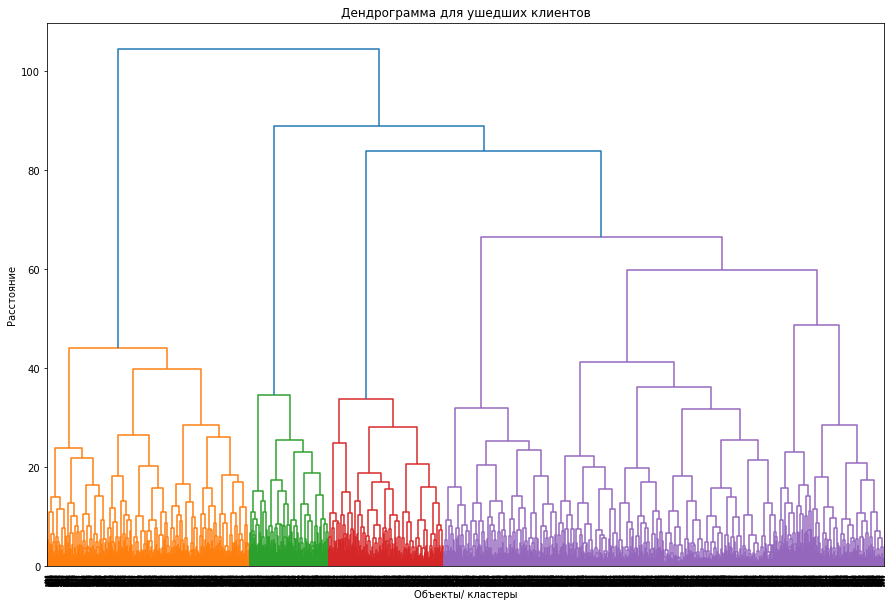

In [48]:
plt.figure(figsize=(15, 10))
Z = linkage(X_st, method='ward') 
plt.title('Дендрограмма для ушедших клиентов')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
dendrogram(Z, orientation='top')
plt.show();

#### Видим 4 кластера. Далее посмотрим по "методу локтя"

$\blacktriangleright$ Усеченная дендрограмма: визуализация заданного числа кластеров

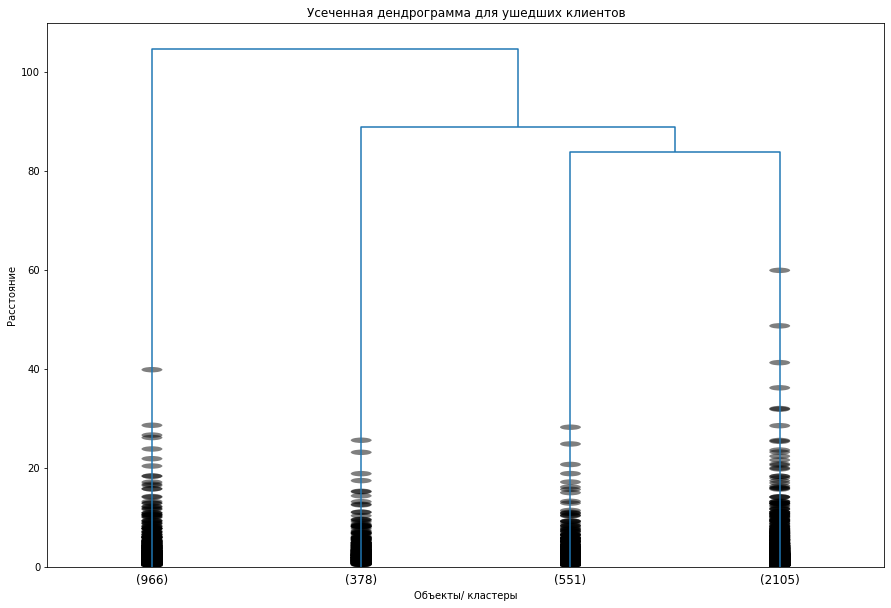

In [49]:
plt.figure(figsize=(15, 10))
dendrogram(Z, 
           truncate_mode = 'lastp',
           p=4,                    
           show_contracted = True)
plt.title('Усеченная дендрограмма для ушедших клиентов')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
plt.show();

In [50]:
agl_cluster_label = fcluster(Z, 4, criterion='maxclust')
agl_cluster_label

array([2, 1, 4, ..., 1, 4, 2], dtype=int32)

$\blacktriangleright$ Метод "локтя". Воспользуемся данным методом для определения оптимального числа кластеров

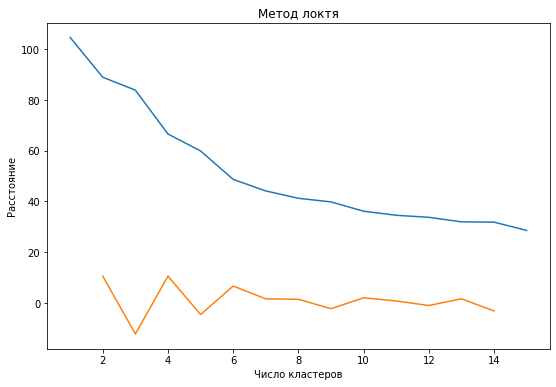

Оптимальное число кластеров: 4


In [51]:
plt.figure(figsize=(9, 6))
last = Z[-15:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1,1)
plt.xlabel('Число кластеров')
plt.ylabel('Расстояние')
plt.title('Метод локтя')
plt.plot(idxs, last_rev)
acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2
print("Оптимальное число кластеров:", k)

$\blacktriangleright$ Неиерархическая кластеризация методом `k-means`. Прогнозирование меток кластеров для объектов(клиентов).

Число кластеров `k=4`.

In [52]:
km = KMeans(n_clusters = 4, random_state = 42)
notagl_cluster_label = km.fit_predict(X_st)

$\blacktriangleright$ Записываем метки кластеров для клиентов и сравним результаты кластеризации хотя бы по численности кластеров 

In [53]:
df['agl_cluster_label'] = agl_cluster_label
df['notagl_cluster_label'] = notagl_cluster_label

In [54]:
df.groupby('agl_cluster_label')['agl_cluster_label'].count()

agl_cluster_label
1     966
2     378
3     551
4    2105
Name: agl_cluster_label, dtype: int64

In [55]:
df.groupby('notagl_cluster_label')['notagl_cluster_label'].count()

notagl_cluster_label
0    1078
1    1483
2     386
3    1053
Name: notagl_cluster_label, dtype: int64

In [58]:
rating_cluster = df.groupby('notagl_cluster_label').mean().reset_index().sort_values(by = 'churn', ascending = False)
rating_cluster.T

,1,2,3,0
notagl_cluster_label,1.00,2.00,3.00,0.00
gender,0.49,0.52,0.54,0.50
near_location,0.76,0.86,0.86,0.94
partner,0.38,0.47,0.34,0.78
promo_friends,0.19,0.31,0.21,0.57
phone,1.00,0.00,1.00,1.00
contract_period,1.90,4.78,2.40,10.70
group_visits,0.29,0.43,0.45,0.54
age,28.04,29.30,30.01,29.91
avg_additional_charges_total,129.64,144.21,157.55,161.36


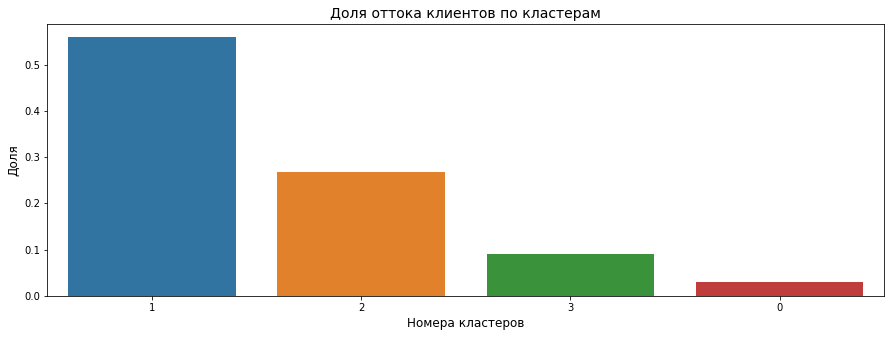

In [62]:
fig, ax = plt.subplots(figsize = (15,5))
ax = sns.barplot(x='notagl_cluster_label', y='churn', data = rating_cluster, 
                order = rating_cluster.notagl_cluster_label.to_list())
ax.set_title('Доля оттока клиентов по кластерам',fontsize = 14)
plt.xlabel('Номера кластеров',fontsize = 12)
plt.ylabel('Доля', fontsize = 12)
for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.2f}%'.format(100*y), 
            (x.mean(), y),ha='center', va='bottom', fontsize = 10);

$\blacktriangleright$ Распределение категориальных признаков по кластерам

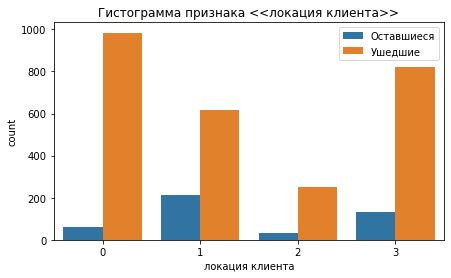

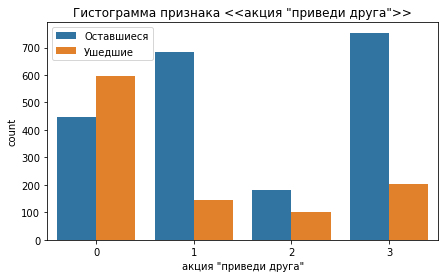

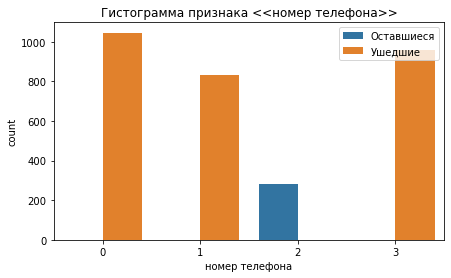

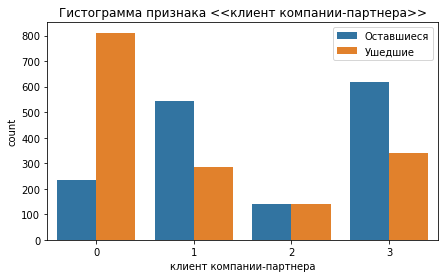

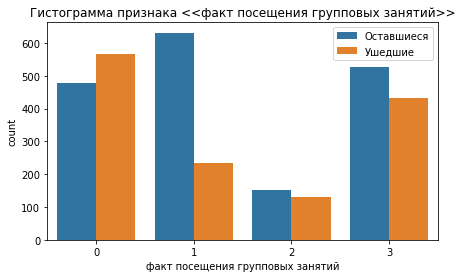

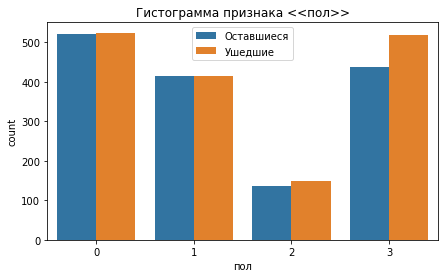

In [60]:
for col in list(set(cat_var)-set(['churn'])):
    plt.figure(figsize=(7,4))
    sns.countplot(data=df[df.churn == 1], x='notagl_cluster_label', hue=col)
    sns.countplot(data=df[df.churn == 0], x='notagl_cluster_label', hue=col)
    plt.title("Гистограмма признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col])
    plt.legend(['Оставшиеся', 'Ушедшие'])
    plt.show()

$\blacktriangleright$ Распределение интервальных признаков по кластерам

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

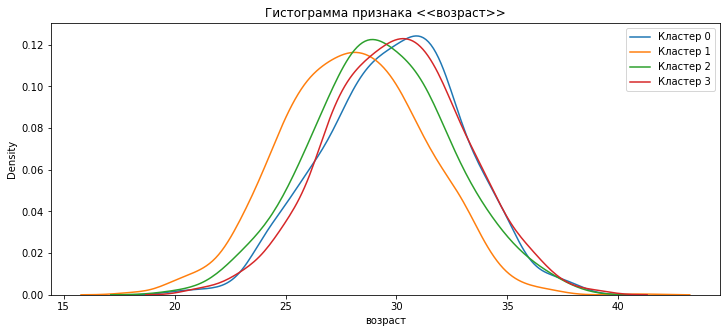

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

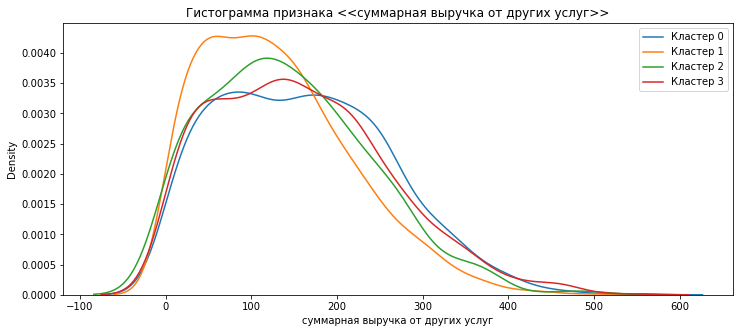

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

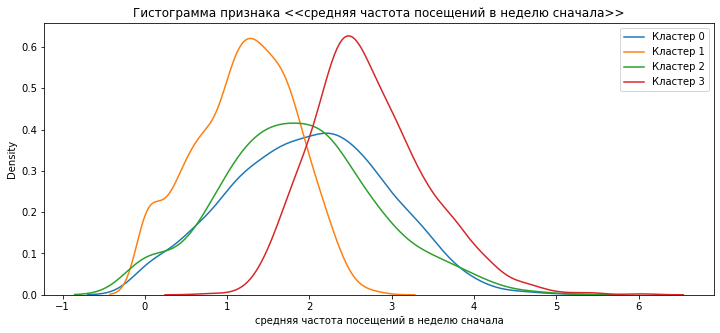

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

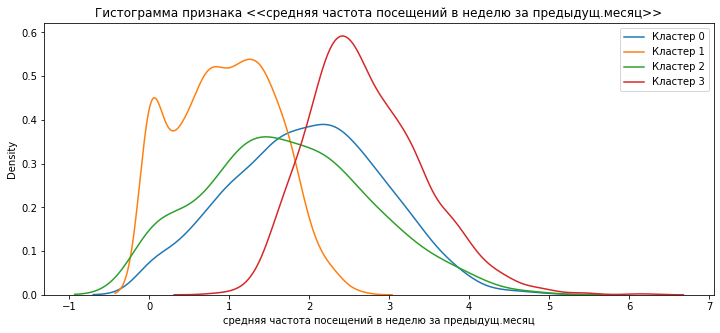

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

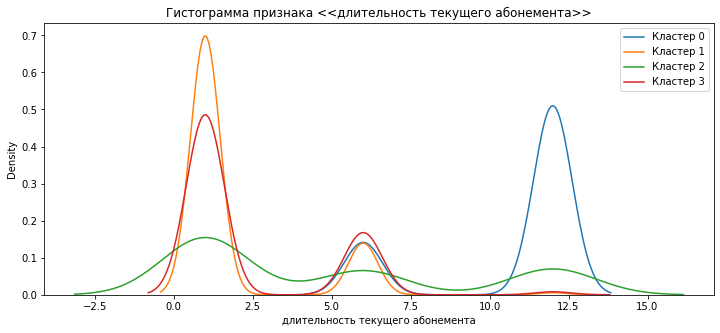

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

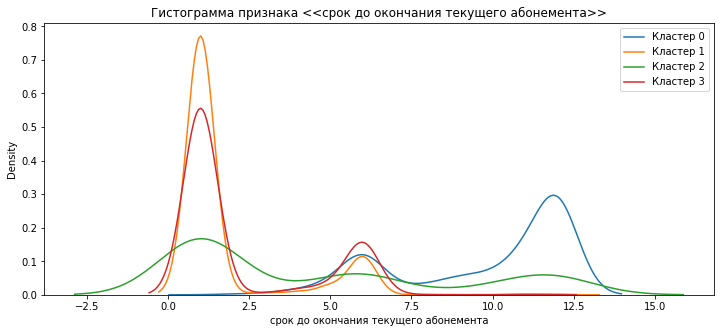

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

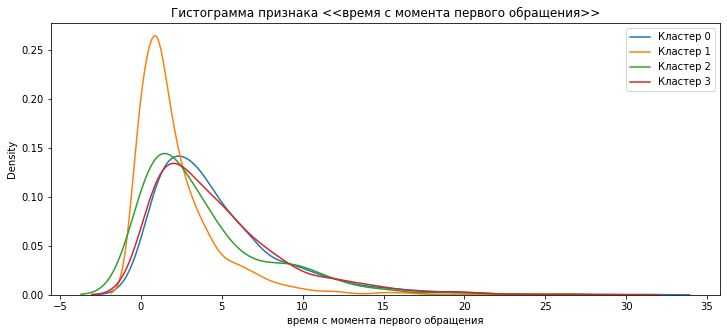

In [61]:
for col in intrval_var:
    plt.figure(figsize=(12,5))
    for cluster in range(0,5): 
        sns.distplot(df[(df.notagl_cluster_label == cluster)][col], 
                     hist = False, label ='Кластер {}'.format(cluster) )
        plt.title("Гистограмма признака <<{}>>".format(dict_to_rus[col]))
        plt.xlabel(dict_to_rus[col])
        plt.legend()
    plt.show()

<a class="anchor" id="desc_cluster"></a>
**Промежуточный вывод:** Охарактеризуем каждый из полученных кластеров:
- **Кластер 1**: 
    - имеет максимальный отток клиентов -- 56%;
    - большинство из них живет или работает недалеко от фитнес-центра;
    - большинство из них не является работниками компаний-партнеров, не пришли в центр по совету друзей, не посещали групповые занятия;
    - менее 2 раз в неделю посещали занятия как за все время, так и в последний месяц;
    - большинство обладатели абонементов на 1-3 месяца;
    - меньше всего посещали занятия как за все время, так и в последний месяц;
    - меньше всех приобретают дополнительные услуги в фитнес-центре;
    - до конца действующего абонемента в основном осталось 2.5 месяца;
    - в среднем фитнес-центр посещают менее 1 месяца;
    
- **Кластер 2**:
    - имеет отток клиентов около 27%;
    - большинство из них живет или работает недалеко от фитнес-центра;
    - работники компаний-партнеров одинаково уходят и остаются с центром;
    - многие воспользовались промо-акцией "приведи друга", а также посещают групповые занятия;
    - обладают абонементами на 3-6 месяца;
    - около 2 раз в неделю посещали занятия как за все время, так и в последний месяц;
    - большинство из них не указали контактный телефон;
    - большинство из них что-то очень разочаровало, т.к. у них еще 4.5 месяца до конца действующего абонемента;
    - в среднем фитнес-центр посещают более 1 месяца;
- **Кластер 3**:
    - имеет отток клиентов около 9%;
    - очень многие из них живут или работают недалеко от фитнес-центра;
    - большинство из них не является работниками компаний-партнеров, не пришли в центр по совету друзей, не посещали групповые занятия;
    - многие посещали групповые занятия;
    - не менее 3 раз в неделю посещали занятия как за все время, так и в последний месяц;
    - большинство обладатели абонементов на 1-3 месяца;
    - не менее 3 раз в неделю посещали занятия как за все время, так и в последний месяц;
    - до конца действующего абонемента в основном осталось 2.5 месяца;
    - фитнес-центр посещают около 3 месяца;
- **Кластер 0**:
    - имеет отток клиентов около 3%;
    - практически все из них живут или работают недалеко от фитнес-центра;
    - большинство из них является работниками компаний-партнеров и пришли в центр по совету друзей;
    - многие посещали групповые занятия;
    - большинство обладает абонементами на 12 месяцев;
    - около 2 раз в неделю посещали занятия как за все время, так и в последний месяц;
    - до конца действующего абонемента осталось 10 месяцев;
    - достаточно много тратят на дополнительные услуги;
    - фитнес-центр посещают не менее 4 месяцев;

#### Вывод: В данной задаче приблизительный портрет оттекающего клиента можно посмотреть по кластеру "1".

### Проверка гипотез

Учитывая, что наша выборка имеет дисбаланс, то разделим наши выборки и сравним средние бутстрап методом.

In [66]:
def get_bootstrap(
        data_column_1, 
        data_column_2, 
        boot_it=1000,  
        statistic=np.mean, 
        bootstrap_conf_level=0.95,  
        alpha=0.05
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True
        ).values

        samples_2 = data_column_2.sample(
            boot_len,  
            replace=True
        ).values

        boot_data.append(statistic(samples_1 - samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу")
    else: 
        print("Не получилось отвергнуть нулевую гипотезу")
    return {"quants": quants,
            "p_value": p_value}

In [69]:
df_churn = df[df['churn'] == 1]
df_not_churn = df[df['churn'] == 0]

$\blacktriangleright$ Проверка гипотезы признака `age`.

Итак, нулевая гипотеза гласит нам о том, что средний возраст в наших группах одинаковый, а альтернативная гипотеза о том, что возраст отличается.

  0%|          | 0/100 [00:00<?, ?it/s]

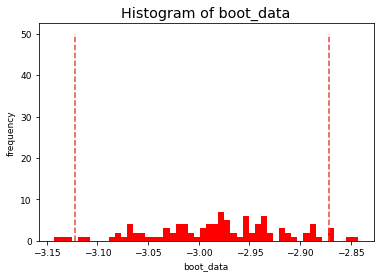

Отвергаем нулевую гипотезу


{'quants':          0
 0.03 -3.12
 0.97 -2.87,
 'p_value': 0.0}

In [70]:
get_bootstrap(df_churn.age, df_not_churn.age, boot_it = 100, statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

Разница в возрасте между оставшимися и ушедшими клиентами статистически значима. Можно сказать, что люди, которые уходят, младше, чем те, которые остаются.

$\blacktriangleright$ Проверка гипотезы признака `avg_additional_charges_total`.

Здесь мы проверим насколько статистически значима разница по тратам на доп.услуги. 

  0%|          | 0/100 [00:00<?, ?it/s]

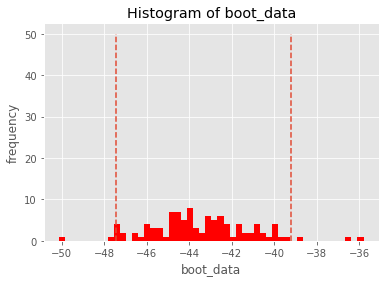

Отвергаем нулевую гипотезу


{'quants':           0
 0.03 -47.46
 0.97 -39.21,
 'p_value': 3.721230318810048e-74}

In [71]:
get_bootstrap(df_churn.avg_additional_charges_total, df_not_churn.avg_additional_charges_total, boot_it = 100, statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

Разница по тратам на доп.услуги между оставшимися и ушедшими клиентами статистически значима. Можно сказать, что люди, которые уходят, тратятся на доп.услуги меньше, чем те, которые остаются.

$\blacktriangleright$ Проверка гипотезы признака `avg_class_frequency_total`.

Здесь мы проверим насколько статистически значима разница частоты посещений в неделю. 

  0%|          | 0/100 [00:00<?, ?it/s]

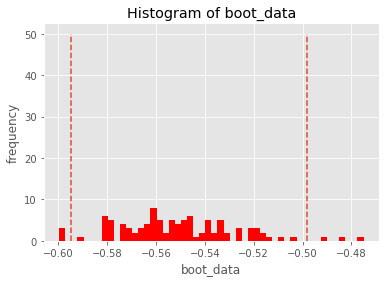

Отвергаем нулевую гипотезу


{'quants':          0
 0.03 -0.59
 0.97 -0.50,
 'p_value': 3.498837368619626e-116}

In [73]:
get_bootstrap(df_churn.avg_class_frequency_total, df_not_churn.avg_class_frequency_total, boot_it = 100, statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

Разница по частоте посещений между оставшимися и ушедшими клиентами статистически значима. Можно сказать, что люди, которые уходят, посещают центр реже, чем те, которые остаются.

$\blacktriangleright$ Проверка гипотез категориальных признаков.

In [76]:
def check_ratio(What_check):
    a = df.groupby([What_check, 'churn'])['churn'].count().rename("ratio")
    b = a /  a.groupby(level=0).sum() 
    dfs = pd.DataFrame(data=b)
    return dfs.style.bar()

In [77]:
check_ratio('gender')

Гендерная принадлежность не влияет на отток.

In [79]:
check_ratio('near_location')

Близость к центру влияет на то, чтобы клиент осталься. Чем дальше локация центра, тем больше человек покидают его.

In [80]:
check_ratio('partner')

По данной статистике можем сказать, что на отток влияет факт о том, те клиенты, которые являются сотрудниками компании-партнера, чаще остаются с центром. 

In [81]:
check_ratio('promo_friends')

Также можем сказать и о признаке "promo_friends". клиенты, которые пришли в центр по акции "пригласи друга", чаще остаются с центром.

In [82]:
check_ratio('phone')

А вот оставил ли клиент свой номер телефона или нет - на отток никак не влияет.

In [83]:
check_ratio('contract_period')

Статистика хорошо показывает что чем меньше длительность текущего абонемента, тем выше вероятность, что клиент уйдет. 

In [84]:
check_ratio('group_visits')

Клиенты не посещающие групповые занятия более склонны к оттоку.

In [85]:
check_ratio('month_to_end_contract')

Статистика показывает, что чем меньше срок до оканчания текущего абонемента, тем больше вероятности оттока клиента. 

In [88]:
check_ratio('lifetime')

Здесь видим, что новички не стабильны. Поддержка клиента требуется 10 месяцев для предотвращения оттока.

### Построение модели

In [90]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import itertools

C:\Users\User\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Разделим данные на train/test
- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['churn'], axis=1), df['churn'], test_size=0.25, random_state=42, stratify=df['churn'])

Соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля.

In [92]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [93]:
categ_var = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 
             'month_to_end_contract', 'lifetime']

Посмотрим как это работает на примере отдельного категориального признака - gender

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='gender')),
                ('ohe', OHEEncoder(key='gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,gender_0,gender_1
2447,1,0
1560,0,1
2048,0,1


Аналогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [96]:
numr = Pipeline([
                ('selector', NumberSelector(key='age')),            
            ])

numr.fit(X_train)
numr.transform(X_test).head(3)

,age
2447,29
1560,30
2048,29


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [97]:
final_transformers = list()

for cat_col in categ_var:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in interval_:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [98]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

In [99]:
models_results = {
    'approach': [],
    'F-Score': [],
    'Precision': [],
    'Recall': [],
}

### RandomForestClassifier

In [100]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42))
    ])

In [101]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='gender'))])),
                                                ('near_location',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='near_location')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='near_location'))])),
                                                ('partner',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector...
                                                ('avg_class_frequency_total',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='avg_class_frequency_total')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('avg_class_frequency_current_month',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='avg_class_frequency_current_month')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [102]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.5 , 0.05, 0.01, 0.31, 0.01, 0.05, 0.59, 0.05, 0.01, 0.12])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [103]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.390000, F-Score=0.851, Precision=0.839, Recall=0.864


Отрисуем матрицу ошибок

In [104]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

C:\Users\User\AppData\Local\Temp\ipykernel_3456\856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Confusion matrix, without normalization
[[691  44]
 [ 41 224]]


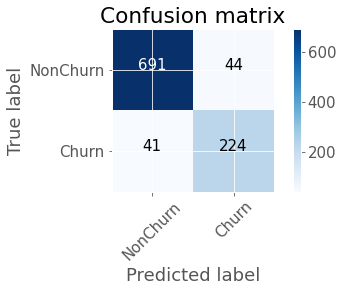

In [105]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

Видим, что модель предсказывала не случайно и чаще отвечала верно.

In [106]:
models_results['approach'].append('RandomForestClassifier')
models_results['F-Score'].append(0.851)
models_results['Precision'].append(0.839)
models_results['Recall'].append(0.864)

### LogisticRegression

для логистической регресси выполню масштабирование

In [107]:
scaler_std = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train_norm[interval_] = scaler_std.fit_transform(X_train_norm[interval_])
X_test_norm[interval_] = scaler_std.transform(X_test_norm[interval_])

In [108]:
pipeline.fit(X_train_norm, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='gender'))])),
                                                ('near_location',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='near_location')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='near_location'))])),
                                                ('partner',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector...
                                                ('avg_class_frequency_total',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='avg_class_frequency_total')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('avg_class_frequency_current_month',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='avg_class_frequency_current_month')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [109]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test_norm)[:, 1]
preds[:10]

array([0.5 , 0.05, 0.01, 0.31, 0.01, 0.05, 0.59, 0.05, 0.01, 0.12])

In [110]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.390000, F-Score=0.851, Precision=0.839, Recall=0.864


C:\Users\User\AppData\Local\Temp\ipykernel_3456\856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Confusion matrix, without normalization
[[691  44]
 [ 41 224]]


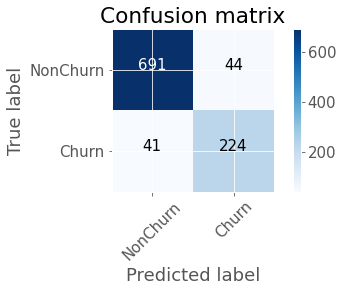

In [111]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [112]:
models_results['approach'].append('LogisticRegression')
models_results['F-Score'].append(0.851)
models_results['Precision'].append(0.839)
models_results['Recall'].append(0.864)

### XGBClassifier

In [113]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 0))
])

In [114]:
pipeline.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='gender'))])),
                                                ('near_location',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='near_location')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='near_location'))])),
                                                ('partner',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [115]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([1.6197021e-01, 1.5461250e-03, 2.4248911e-04, 9.3634164e-01,
       1.2543543e-04, 1.9224144e-04, 6.3454050e-01, 1.3891065e-03,
       8.8880153e-04, 1.1894017e-03], dtype=float32)

In [116]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.279395, F-Score=0.879, Precision=0.870, Recall=0.887


C:\Users\User\AppData\Local\Temp\ipykernel_3456\856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Confusion matrix, without normalization
[[700  35]
 [ 31 234]]


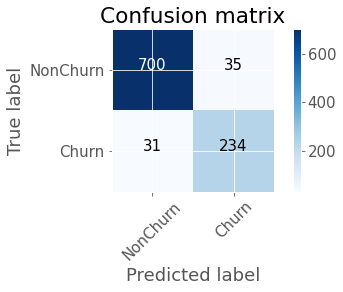

In [117]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [118]:
models_results['approach'].append('XGBClassifier')
models_results['F-Score'].append(0.879)
models_results['Precision'].append(0.870)
models_results['Recall'].append(0.887) 

In [119]:
pd.DataFrame( models_results)

,approach,F-Score,Precision,Recall
0,RandomForestClassifier,0.85,0.84,0.86
1,LogisticRegression,0.85,0.84,0.86
2,XGBClassifier,0.88,0.87,0.89


XGBClassifier показала лучшие результаты по всем метрикам.

### Оценка экономической эффективности

In [120]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

TN, FP, FN, TP

(700, 35, 31, 234)

In [121]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8830188679245283, 0.047619047619047616, 0.9523809523809523)

FPR (False Positive Rate) 0.048. Это значит, что почти 5 % клиентов определяются как "готовые к оттоку" некоректно. 